**Author**: Andy Tzanidakis \
Last updated: May 05, 2024

## Overview



- Learn how to use VizieR TAP query to access tables and store/handle them in `LSDB`
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Pass HipsCat LSDB catalogs to `TAPE` to perform time-series analysis and exploration


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2

import lsdb
from lsdb.core.search import ConeSearch
import tape
from tape import Ensemble, ColumnMapper

import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'}) # store dask temporary files on SSD...
dask.config.set({"dataframe.shuffle-compression": 'Snappy'}) # snappy algorithm for shuffle compression

from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## VizieR Querying

In [3]:
## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

In [4]:
# the catalogue name in VizieR (Gaia DR3 part 6)
CATALOGUE = "I/360"

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [5]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


In [6]:
# Let's read quickly the table description...
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Subjects: I/360
Waveband Coverage: optical
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [7]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [8]:
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS BETWEEN 0 and 55) AND (RA_ICRS BETWEEN 0 and 55)')

In [9]:
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [10]:
len(table_df)

137383

Text(0, 0.5, 'DEC [deg]')

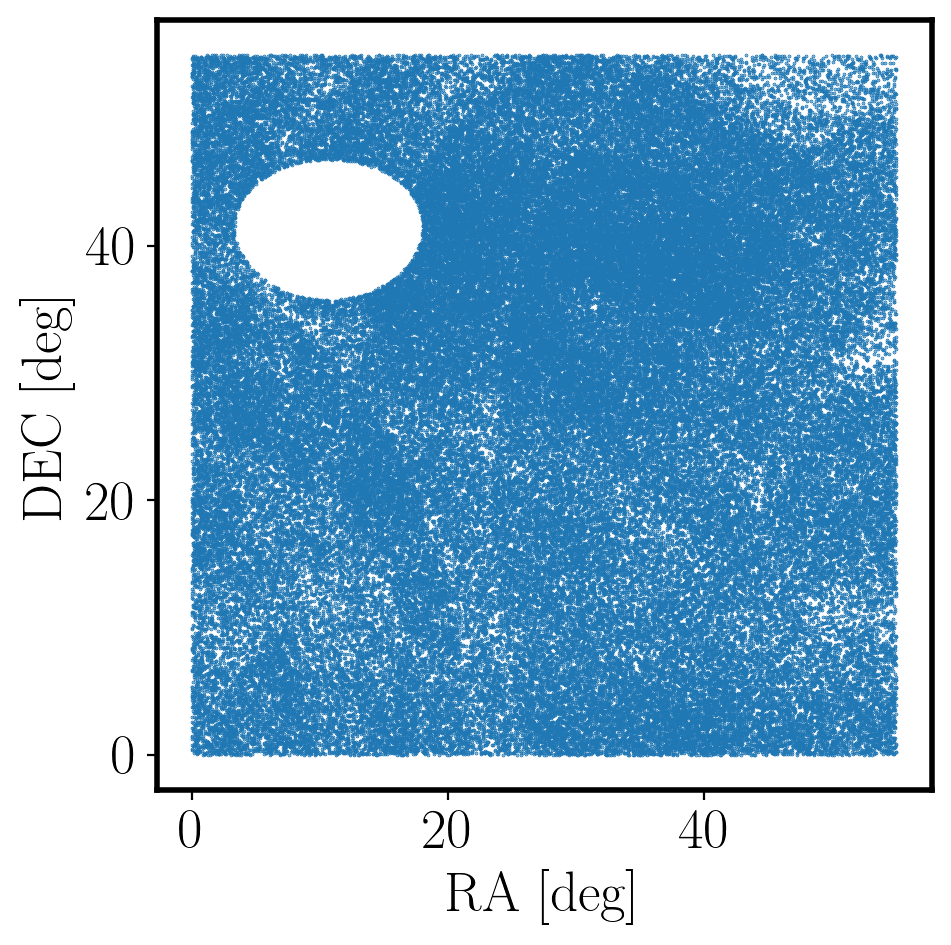

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(table_df['RA_ICRS'], table_df['DE_ICRS'], s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [14]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [15]:
table_df.head(1)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
65,1355,100225574408599040,3445.0815,5.0035,-0.501,0.5926,0.3662,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,M,32.323798,21.050474,32.323798,21.050474


In [16]:
len(table_df)

1892

In [17]:
client = Client(n_workers=6, threads_per_worker=1, memory_limit='auto')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39291 instead
  warnings.warn(


In [18]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39291/status,
Dashboard: http://127.0.0.1:39291/status,Workers: 6
Total threads: 6,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44173,Workers: 6
Dashboard: http://127.0.0.1:39291/status,Total threads: 6
Started: Just now,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:42894,Total threads: 1
Dashboard: http://127.0.0.1:36803/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:34577,


In [19]:
np.shape(table_df)

(1892, 26)

In [25]:
%%time

# Hipsccat VizieR table
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS",
    lowest_order=5)

CPU times: user 48.3 s, sys: 4.02 s, total: 52.3 s
Wall time: 52.4 s


In [27]:
hips_object

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,[M/H]-S,Rad-F,Lum-F,Mass-F,Age-F,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs,Norder,Dir,Npix
npartitions=700,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64
1125899906842624,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554989257637756928,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


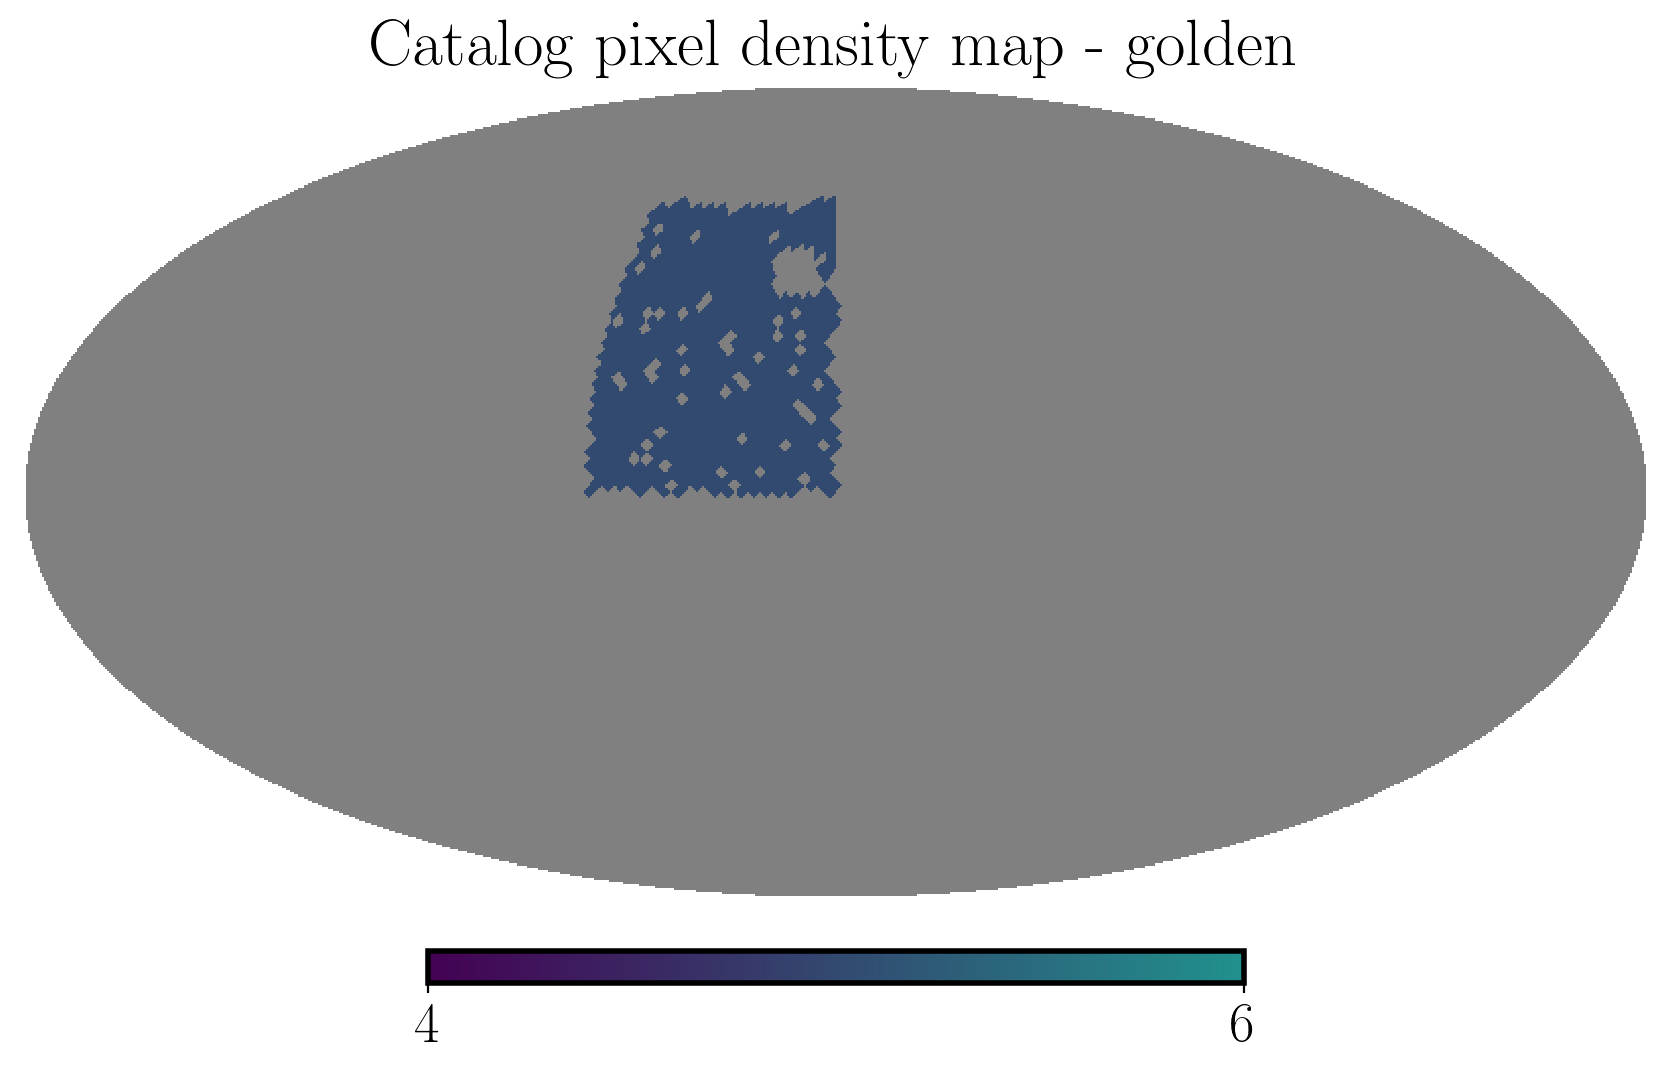

In [28]:
from hipscat.inspection import plot_pixels
plot_pixels(hips_object.hc_structure)

In [18]:
%%time
hips_object.head(1)

CPU times: user 69.9 ms, sys: 14.2 ms, total: 84.1 ms
Wall time: 147 ms


,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
197754504609792,3267192,98857263018112,3542.0205,4.8119,-0.6898,0.4936,0.2947,NaN,NaN,NaN,...,NaN,<NA>,M,44.655283,0.729574,44.655283,0.729574,0,0,0


## Load Additional Catalogs

In [83]:
# load ZTF source table
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource",
                                 search_filter=ConeSearch(ra=27.5, dec=27.5, radius_arcsec=27.5*3600))

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14",
                        columns=['ps1_objid', 'nobs_r', 'nobs_g', 'ra', 'dec'],
                          search_filter=ConeSearch(ra=27.5, dec=27.5, radius_arcsec=27.5*3600)) # select only Nobs (gr) bands

In [84]:
ztf

,ps1_objid,nobs_r,nobs_g,ra,dec
npartitions=133,,,,,
0,int64,int32,int32,float64,float64
18014398509481984,...,...,...,...,...
...,...,...,...,...,...
5760103923406864384,...,...,...,...,...
18446744073709551615,...,...,...,...,...


## Crossmatch

In [85]:
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, 
                                                  n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


In [86]:
xmatch_golden_ztf_object

,recno_golden,Source_golden,Teff-P_golden,logg-P_golden,[M/H]-P_golden,AG-P_golden,E(BP-RP)-P_golden,[alphe/Fe]-S_golden,Teff-S_golden,logg-S_golden,[M/H]-S_golden,Rad-F_golden,Lum-F_golden,Mass-F_golden,Age-F_golden,evol-F_golden,Rad-FS_golden,Lum-FS_golden,Mass-FS_golden,Age-FS_golden,evol-FS_golden,SpType_golden,RA_ICRS_golden,DE_ICRS_golden,_RA_icrs_golden,_DE_icrs_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
npartitions=659,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64
1125899906842624,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754474423872651264,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [87]:
xmatch_golden_ztf_object.head(1)

,recno_golden,Source_golden,Teff-P_golden,logg-P_golden,[M/H]-P_golden,AG-P_golden,E(BP-RP)-P_golden,[alphe/Fe]-S_golden,Teff-S_golden,logg-S_golden,...,_DE_icrs_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
481334199844864,836445,240659903086080,3517.203,4.9446,-0.4659,0.4517,0.2743,NaN,NaN,NaN,...,1.352263,5,0,0,109620454930383213,51,52,45.493219,1.352271,0.245953


In [ ]:
#%%time
# Head of xmatch table with 250k rows for exploration
#xmatch_golden_ztf_object_comp = xmatch_golden_ztf_object.compute()

In [ ]:
%%time
hips_object_v2 = lsdb.from_dataframe(
    xmatch_golden_ztf_object_comp,
    catalog_name="golden",
    catalog_type="object",
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14")

In [ ]:
xmatch_golden_ztf_object_comp.keys()

In [ ]:
plt.figure(figsize=(4, 5))
plt.scatter(xmatch_golden_ztf_object_comp['Teff-P_golden'],
             np.log(xmatch_golden_ztf_object_comp['Lum-F_golden']), s=1, 
             color='#28282B')
plt.xlim(plt.xlim(3200, 4700)[::-1])
plt.ylim(-6, -1)
plt.minorticks_on()
plt.xlabel(r"$T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L/L_\odot$")


In [88]:
%%time
# sync source catalog data to object (xmatched) object
_sources = xmatch_golden_ztf_object.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 714 ms, sys: 101 ms, total: 815 ms
Wall time: 748 ms


## TAPE

In [89]:
# Initialize an Ensemble
ens = Ensemble(client=client)
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37361/status,
Dashboard: http://127.0.0.1:37361/status,Workers: 6
Total threads: 6,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39912,Workers: 6
Dashboard: http://127.0.0.1:37361/status,Total threads: 6
Started: 39 minutes ago,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:46325,Total threads: 1
Dashboard: http://127.0.0.1:46879/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:42176,


In [96]:
_sources

,recno_golden_golden_x_ztf_dr14,Source_golden_golden_x_ztf_dr14,Teff-P_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,[M/H]-P_golden_golden_x_ztf_dr14,AG-P_golden_golden_x_ztf_dr14,E(BP-RP)-P_golden_golden_x_ztf_dr14,[alphe/Fe]-S_golden_golden_x_ztf_dr14,Teff-S_golden_golden_x_ztf_dr14,logg-S_golden_golden_x_ztf_dr14,[M/H]-S_golden_golden_x_ztf_dr14,Rad-F_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Mass-F_golden_golden_x_ztf_dr14,Age-F_golden_golden_x_ztf_dr14,evol-F_golden_golden_x_ztf_dr14,Rad-FS_golden_golden_x_ztf_dr14,Lum-FS_golden_golden_x_ztf_dr14,Mass-FS_golden_golden_x_ztf_dr14,Age-FS_golden_golden_x_ztf_dr14,evol-FS_golden_golden_x_ztf_dr14,SpType_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,_RA_icrs_golden_golden_x_ztf_dr14,_DE_icrs_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,index_ztf_zource,ps1_objid_ztf_zource,ra_ztf_zource,dec_ztf_zource,ps1_gMeanPSFMag_ztf_zource,ps1_rMeanPSFMag_ztf_zource,ps1_iMeanPSFMag_ztf_zource,nobs_g_ztf_zource,nobs_r_ztf_zource,nobs_i_ztf_zource,mean_mag_g_ztf_zource,mean_mag_r_ztf_zource,mean_mag_i_ztf_zource,catflags_ztf_zource,fieldID_ztf_zource,mag_ztf_zource,magerr_ztf_zource,mjd_ztf_zource,rcID_ztf_zource,band_ztf_zource,Norder_ztf_zource,Dir_ztf_zource,Npix_ztf_zource
npartitions=1332,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9007199254740992,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,uint8,uint64,uint64
10133099161583616,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755318848802783232,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [100]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd_ztf_zource',
        flux_col='mag_ztf_zource',
        err_col='magerr_ztf_zource',
        band_col='band_ztf_zource',
      )


ens.from_lsdb(
    source_catalog=_sources,
    object_catalog=xmatch_golden_ztf_object,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

In [98]:
ens.source

,recno_golden_golden_x_ztf_dr14,Source_golden_golden_x_ztf_dr14,Teff-P_golden_golden_x_ztf_dr14,logg-P_golden_golden_x_ztf_dr14,[M/H]-P_golden_golden_x_ztf_dr14,AG-P_golden_golden_x_ztf_dr14,E(BP-RP)-P_golden_golden_x_ztf_dr14,[alphe/Fe]-S_golden_golden_x_ztf_dr14,Teff-S_golden_golden_x_ztf_dr14,logg-S_golden_golden_x_ztf_dr14,[M/H]-S_golden_golden_x_ztf_dr14,Rad-F_golden_golden_x_ztf_dr14,Lum-F_golden_golden_x_ztf_dr14,Mass-F_golden_golden_x_ztf_dr14,Age-F_golden_golden_x_ztf_dr14,evol-F_golden_golden_x_ztf_dr14,Rad-FS_golden_golden_x_ztf_dr14,Lum-FS_golden_golden_x_ztf_dr14,Mass-FS_golden_golden_x_ztf_dr14,Age-FS_golden_golden_x_ztf_dr14,evol-FS_golden_golden_x_ztf_dr14,SpType_golden_golden_x_ztf_dr14,RA_ICRS_golden_golden_x_ztf_dr14,DE_ICRS_golden_golden_x_ztf_dr14,_RA_icrs_golden_golden_x_ztf_dr14,_DE_icrs_golden_golden_x_ztf_dr14,Norder_golden_golden_x_ztf_dr14,Dir_golden_golden_x_ztf_dr14,Npix_golden_golden_x_ztf_dr14,ps1_objid_ztf_dr14_golden_x_ztf_dr14,nobs_r_ztf_dr14_golden_x_ztf_dr14,nobs_g_ztf_dr14_golden_x_ztf_dr14,ra_ztf_dr14_golden_x_ztf_dr14,dec_ztf_dr14_golden_x_ztf_dr14,_dist_arcsec_golden_x_ztf_dr14,index_ztf_zource,ps1_objid_ztf_zource,ra_ztf_zource,dec_ztf_zource,ps1_gMeanPSFMag_ztf_zource,ps1_rMeanPSFMag_ztf_zource,ps1_iMeanPSFMag_ztf_zource,nobs_g_ztf_zource,nobs_r_ztf_zource,nobs_i_ztf_zource,mean_mag_g_ztf_zource,mean_mag_r_ztf_zource,mean_mag_i_ztf_zource,catflags_ztf_zource,fieldID_ztf_zource,mag_ztf_zource,magerr_ztf_zource,mjd_ztf_zource,rcID_ztf_zource,band_ztf_zource,Norder_ztf_zource,Dir_ztf_zource,Npix_ztf_zource
npartitions=1332,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9007199254740992,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,uint8,uint64,uint64
10133099161583616,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755318848802783232,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [101]:
ts = ens.to_timeseries(9049076108623872)

(16.677638499438764, 16.40829376466572)

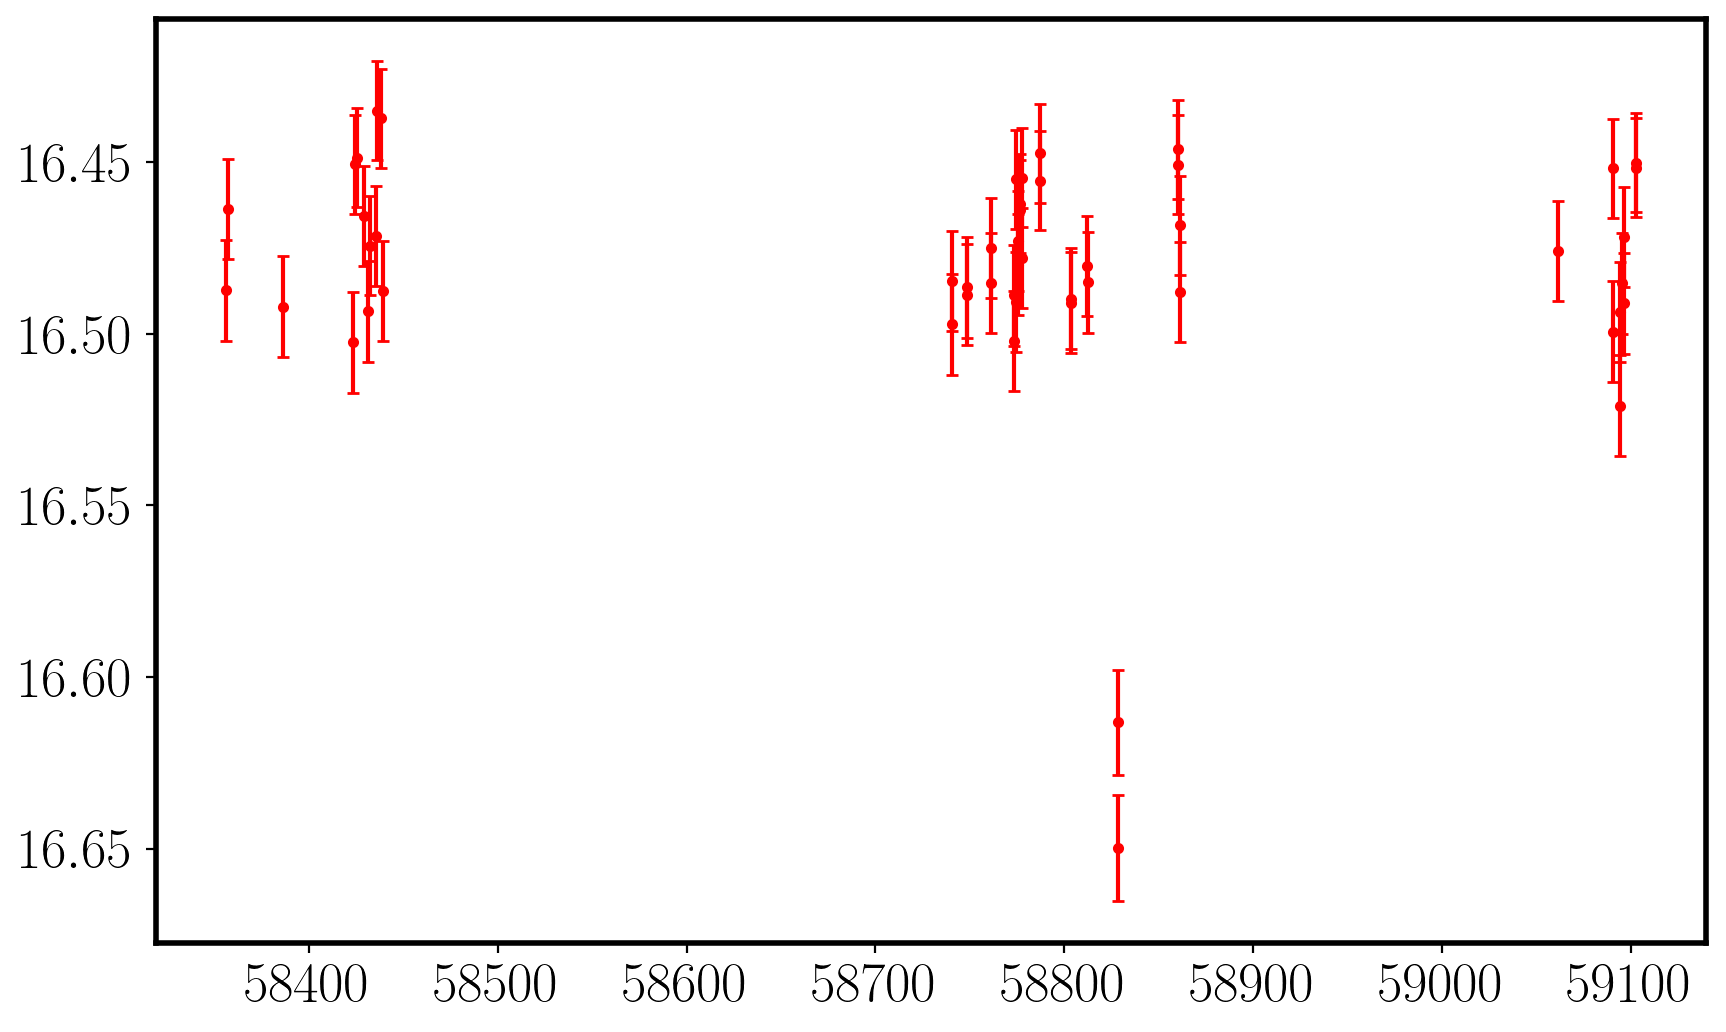

In [112]:
rband = ts.data[ts.band=='r']

plt.figure(figsize=(10, 6))
plt.errorbar(rband.mjd_ztf_zource, rband.mag_ztf_zource, yerr=rband.magerr_ztf_zource, color='r', fmt='.', capsize=2)
plt.ylim(plt.ylim()[::-1])



## Calculating Time-Series Features

In [ ]:
!pip install cesium

In [92]:
from cesium import featurize

In [ ]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [ ]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    # Compute features
    summary_ = {}

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 



In [ ]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

In [ ]:
_sources

In [ ]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

In [ ]:
%%time
#ens.object.join(calc_).update_ensemble()

In [ ]:
client

In [ ]:
dask.config.set({"dataframe.convert-string": False})

In [62]:
%%time
obj_features = calc_.compute()

KilledWorker: Attempted to run task 'perform_join_on-0d672da9-d883-486a-b64f-ba49306503fe' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:42437. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.